In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from zuko.flows.autoregressive import MaskedAutoregressiveTransform
from zuko.transforms import (
    MonotonicAffineTransform,
)
from zuko.flows import UnconditionalDistribution
from torch.distributions import Cauchy, Normal, Laplace, Bernoulli, Uniform
import copy
from causal_cocycle.model_new import ZukoCocycleModel
from causal_cocycle.optimise_new import optimise
from causal_cocycle.loss import CocycleLoss
from causal_cocycle.loss_factory import CocycleLossFactory
from causal_cocycle.kernels import gaussian_kernel
from scipy.stats import betaprime, norm
import numpy as np

class IdentityTransform(nn.Module):
    """
    A no-op bijector: forward(y) = (y, 0); inverse(u) = (u, 0).
    """

    def __init__(self):
        super().__init__()

    def forward(self, y: torch.Tensor):
        batch = y.shape[0]
        return y

    def inverse(self, u: torch.Tensor):
        batch = u.shape[0]
        return u
        
class DiscreteSelectorTransform(nn.Module):
    """
    Wraps K unconditional bijector "factories" (MaskedAutoregressiveTransform or IdentityTransform).
    Calling DiscreteSelectorTransform(x) returns a SelectedBijector. Then:
       - SelectedBijector.inv(u)  dispatches to flows[k].inverse(...)
       - SelectedBijector.forward(y) dispatches to flows[k].forward(...)
    For MaskedAutoregressiveTransform, we pass a dummy zero‐dim context tensor of shape (n_k, 0).
    """

    def __init__(self, flows: nn.ModuleList):
        """
        Args:
          flows: ModuleList of length K, each either:
                 • IdentityTransform()  (nn.Module), or
                 • MaskedAutoregressiveTransform(context=0, …)
        """
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.K = len(flows)

    def __call__(self, x: torch.Tensor):
        """
        Returns a SelectedBijector for the batch of labels x.
        Args:
          x: Tensor of shape (batch, 1) or (batch,), integer labels in {0,…,K-1}.
        """
        return DiscreteSelectorTransform.SelectedBijector(self, x)

# In architectures.py (only the SelectedBijector inner class shown)

    class SelectedBijector:
        def __init__(self, parent: "DiscreteSelectorTransform", x: torch.Tensor):
            self.parent = parent
            self.x_flat = x.view(-1).long()  # shape: (batch,)

        def inv(self, u: torch.Tensor) -> torch.Tensor:
            """
            Latent → data. For each i with label k, apply flows[k].inverse(u[i]).
            """
            batch, y_dim = u.shape
            y_out = torch.zeros_like(u)

            for k in range(self.parent.K):
                mask = (self.x_flat == k)
                if not mask.any():
                    continue
                u_k = u[mask]  # (n_k, y_dim)
                flow_k = self.parent.flows[k]

                if isinstance(flow_k, IdentityTransform):
                    y_k = flow_k.inverse(u_k)
                else:
                    # MaskedAutoregressiveTransform(context=0) → AutoregressiveTransform
                    ctx = u_k.new_empty((u_k.shape[0], 0))
                    bij = flow_k(None)            # AutoregressiveTransform
                    # Use bij.inverse(...) to invert latents → data
                    y_k = bij.inv(u_k)       # returns a single Tensor

                y_out[mask] = y_k

            return y_out

        def forward(self, y: torch.Tensor) -> torch.Tensor:
            """
            Data → latent. For each i with label k, apply flows[k].forward(y[i]).
            """
            batch, y_dim = y.shape
            u_out = torch.zeros_like(y)

            for k in range(self.parent.K):
                mask = (self.x_flat == k)
                if not mask.any():
                    continue
                y_k = y[mask]  # (n_k, y_dim)
                flow_k = self.parent.flows[k]

                if isinstance(flow_k, IdentityTransform):
                    u_k= flow_k.forward(y_k)
                else:
                    # MaskedAutoregressiveTransform(context=0) → AutoregressiveTransform
                    ctx = y_k.new_empty((y_k.shape[0], 0))
                    bij = flow_k(None)         # AutoregressiveTransform
                    # Use __call__ (i.e. bij(y_k)) to map data → latent
                    u_k = bij(y_k)            # returns a single Tensor

                u_out[mask] = u_k

            return u_out

        def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
            """
            Alias so that `transform(u)` invokes `forward(u)`.
            """
            return self.forward(tensor)

In [2]:
# ── Data ─────────────────────────────────────────────────────
N_train = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
U = torch.cat([torch.ones(N_train //2),torch.zeros(N_train // 2)])[:,None]
X = torch.cat([torch.ones(N_train // 4),torch.zeros(N_train // 4),torch.ones(N_train // 4),torch.zeros(N_train // 4)])[:,None]
Y = (X+1)*U
# ── Build loss and transforms ───────────────────────────────
d = 1   # dim(Y)

maf = MaskedAutoregressiveTransform(
        features=1,
        context=0,
        hidden_features=(),
        univariate=MonotonicAffineTransform,
        shapes=[(), ()],
    )
flow0 = IdentityTransform()
flow1 = maf
transform = DiscreteSelectorTransform(nn.ModuleList([flow0, flow1]))
model = ZukoCocycleModel(transforms=torch.nn.ModuleList([transform]))

kernel = [gaussian_kernel(), gaussian_kernel()]
loss_factory = CocycleLossFactory(kernel)
loss = loss_factory.build_loss("CMMD_V", X, Y)

In [3]:
# Example hyperparameters—feel free to adjust as desired:
learn_rate       = 1e-2
epochs           = 500
weight_decay     = 0.0
batch_size       = 128
val_batch_size   = 256
scheduler        = False
schedule_milestone = 10
lr_mult          = 0.90
print_           = True
plot             = False
likelihood_param_opt = False
likelihood_param_lr  = 0.01

# Finally, run training. We supply both train and val sets so optimise can compute validation loss each epoch:
best_model, history = optimise(
    model            = model,
    loss_tr          = loss,
    inputs           = X,
    outputs          = Y,
    inputs_val       = None,
    outputs_val      = None,
    learn_rate       = learn_rate,
    epochs           = epochs,
    weight_decay     = weight_decay,
    batch_size       = batch_size,
    val_batch_size   = val_batch_size,
    scheduler        = scheduler,
    schedule_milestone = schedule_milestone,
    lr_mult          = lr_mult,
    print_           = print_,
    plot             = plot,
    likelihood_param_opt = likelihood_param_opt,
    likelihood_param_lr  = likelihood_param_lr,
    loss_val         = None  # no separate “loss_val” function needed, since CMMD-V is symmetric
)

Epoch 1/500, Training Loss: -0.3804
Epoch 2/500, Training Loss: -0.3805
Epoch 3/500, Training Loss: -0.3806
Epoch 4/500, Training Loss: -0.3808
Epoch 5/500, Training Loss: -0.3809
Epoch 6/500, Training Loss: -0.3810
Epoch 7/500, Training Loss: -0.3810
Epoch 8/500, Training Loss: -0.3811
Epoch 9/500, Training Loss: -0.3812
Epoch 10/500, Training Loss: -0.3813
Epoch 11/500, Training Loss: -0.3813
Epoch 12/500, Training Loss: -0.3814
Epoch 13/500, Training Loss: -0.3814
Epoch 14/500, Training Loss: -0.3815
Epoch 15/500, Training Loss: -0.3815
Epoch 16/500, Training Loss: -0.3815
Epoch 17/500, Training Loss: -0.3816
Epoch 18/500, Training Loss: -0.3816
Epoch 19/500, Training Loss: -0.3816
Epoch 20/500, Training Loss: -0.3817
Epoch 21/500, Training Loss: -0.3817
Epoch 22/500, Training Loss: -0.3818
Epoch 23/500, Training Loss: -0.3818
Epoch 24/500, Training Loss: -0.3819
Epoch 25/500, Training Loss: -0.3819
Epoch 26/500, Training Loss: -0.3820
Epoch 27/500, Training Loss: -0.3820
Epoch 28/5

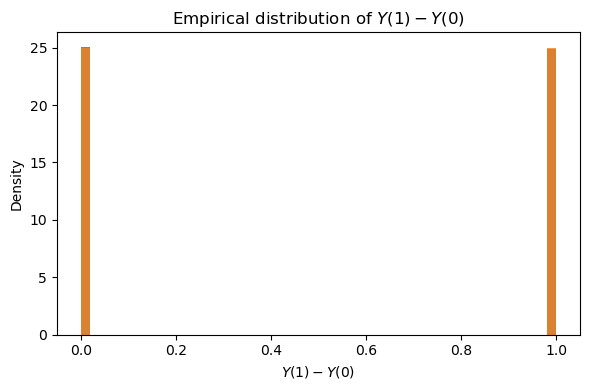

In [4]:
# ── 4) Paired sampling via reseeding ──────────────────────────────────────────
N_effect = 10**5
Y0_eff,X0_eff = Y[X==0][:,None], X[X==0][:,None]
with torch.no_grad():
    Y1_eff = model.cocycle(X0_eff+1,X0_eff,Y0_eff)
delta = (Y1_eff - Y0_eff).squeeze(-1)
Y0 = Bernoulli(1/2).sample((N_effect,)).to(device)
Y1 = Y0*2
true_delta = Y1-Y0


def t(x):
    #return torch.log(x.abs()+1)*torch.sign(x)
    return torch.sigmoid(x)

# ── 5) Plot empirical histogram of ΔY ────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.hist((true_delta), bins=50, density=True, alpha=0.8)
plt.hist((delta), bins=50, density=True, alpha=0.8)
plt.title("Empirical distribution of $Y(1)-Y(0)$")
plt.xlabel("$Y(1)-Y(0)$")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

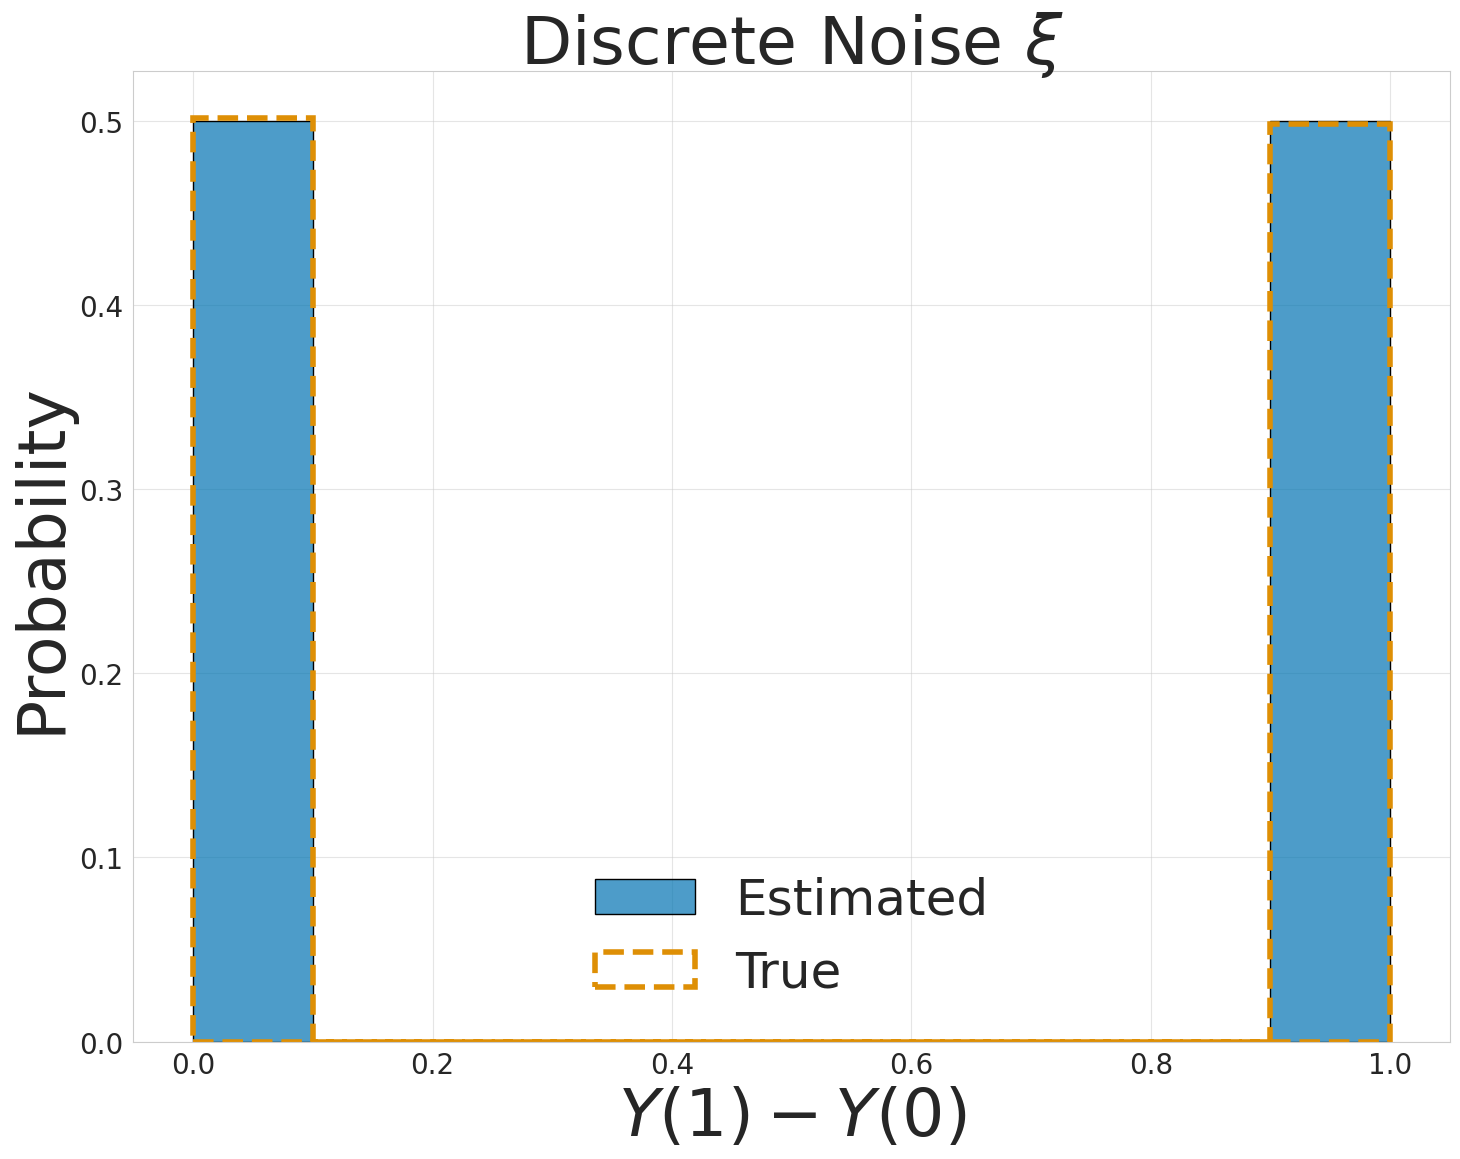

In [13]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
})
sns.set_style("whitegrid")
col_data, col_true = sns.color_palette("colorblind", 2)

# Adjust bins as needed for your support

fig, ax = plt.subplots(figsize=(15, 12))

# Estimated/model histogram
sns.histplot(
    delta, bins=10, stat="probability", alpha=0.7, color=col_data, 
    label="Estimated", ax=ax, edgecolor="black"
)

# True histogram (outline only)
sns.histplot(
    true_delta, bins=10, stat="probability", alpha=0, color=col_true, 
    label="True", ax=ax, edgecolor=col_true, linewidth=4, ls = "dashed",
)

ax.set_xlabel(r"$Y(1) - Y(0)$", fontsize=48)
ax.set_ylabel("Probability", fontsize=48)
ax.set_title(r"Discrete Noise $\xi$", fontsize=48)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.legend(frameon=False, fontsize=36)
ax.grid(alpha=0.5)
fig.tight_layout()
fig.savefig("cocycle_misspec_discrete.png", bbox_inches="tight")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Define fixed x-grid
x_grid = np.linspace(-1, 2, 1000)

# Sort inputs
delta_sorted = np.sort(delta)
true_delta_sorted = np.sort(true_delta)

# Compute empirical CDFs on fixed grid
cdf_delta = np.searchsorted(delta_sorted, x_grid, side="right") / len(delta_sorted)
cdf_true = np.searchsorted(true_delta_sorted, x_grid, side="right") / len(true_delta_sorted)

# Colors
col_data, col_true = sns.color_palette("colorblind", 2)

# Plot
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(24, 24))  # ⬅️ Doubled size

ax.plot(x_grid, cdf_delta, color=col_data, lw=5, label="Estimated")
ax.fill_between(x_grid, 0, cdf_delta, color=col_data, alpha=0.4)
ax.plot(x_grid, cdf_true, color=col_true, lw=7.5, ls="--", label="True")

# Labels with doubled fontsize
ax.set_xlabel(r"$Y(1) - Y(0)$", fontsize=96)
ax.set_ylabel("CDF", fontsize=96)
ax.set_title(r"CMMD - Binary Noise", fontsize=96)

# Tick label size adjustment
ax.tick_params(axis='x', labelsize=72)  # ⬅️ Much larger x-tick labels
ax.tick_params(axis='y', labelsize=48)

# Formatting
ax.set_xlim([-1, 2])
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.legend(frameon=False, fontsize=64)
ax.grid(alpha=0.5)
fig.tight_layout()
fig.savefig("cocycles_misspec_discrete_large.png", bbox_inches="tight")
plt.show()

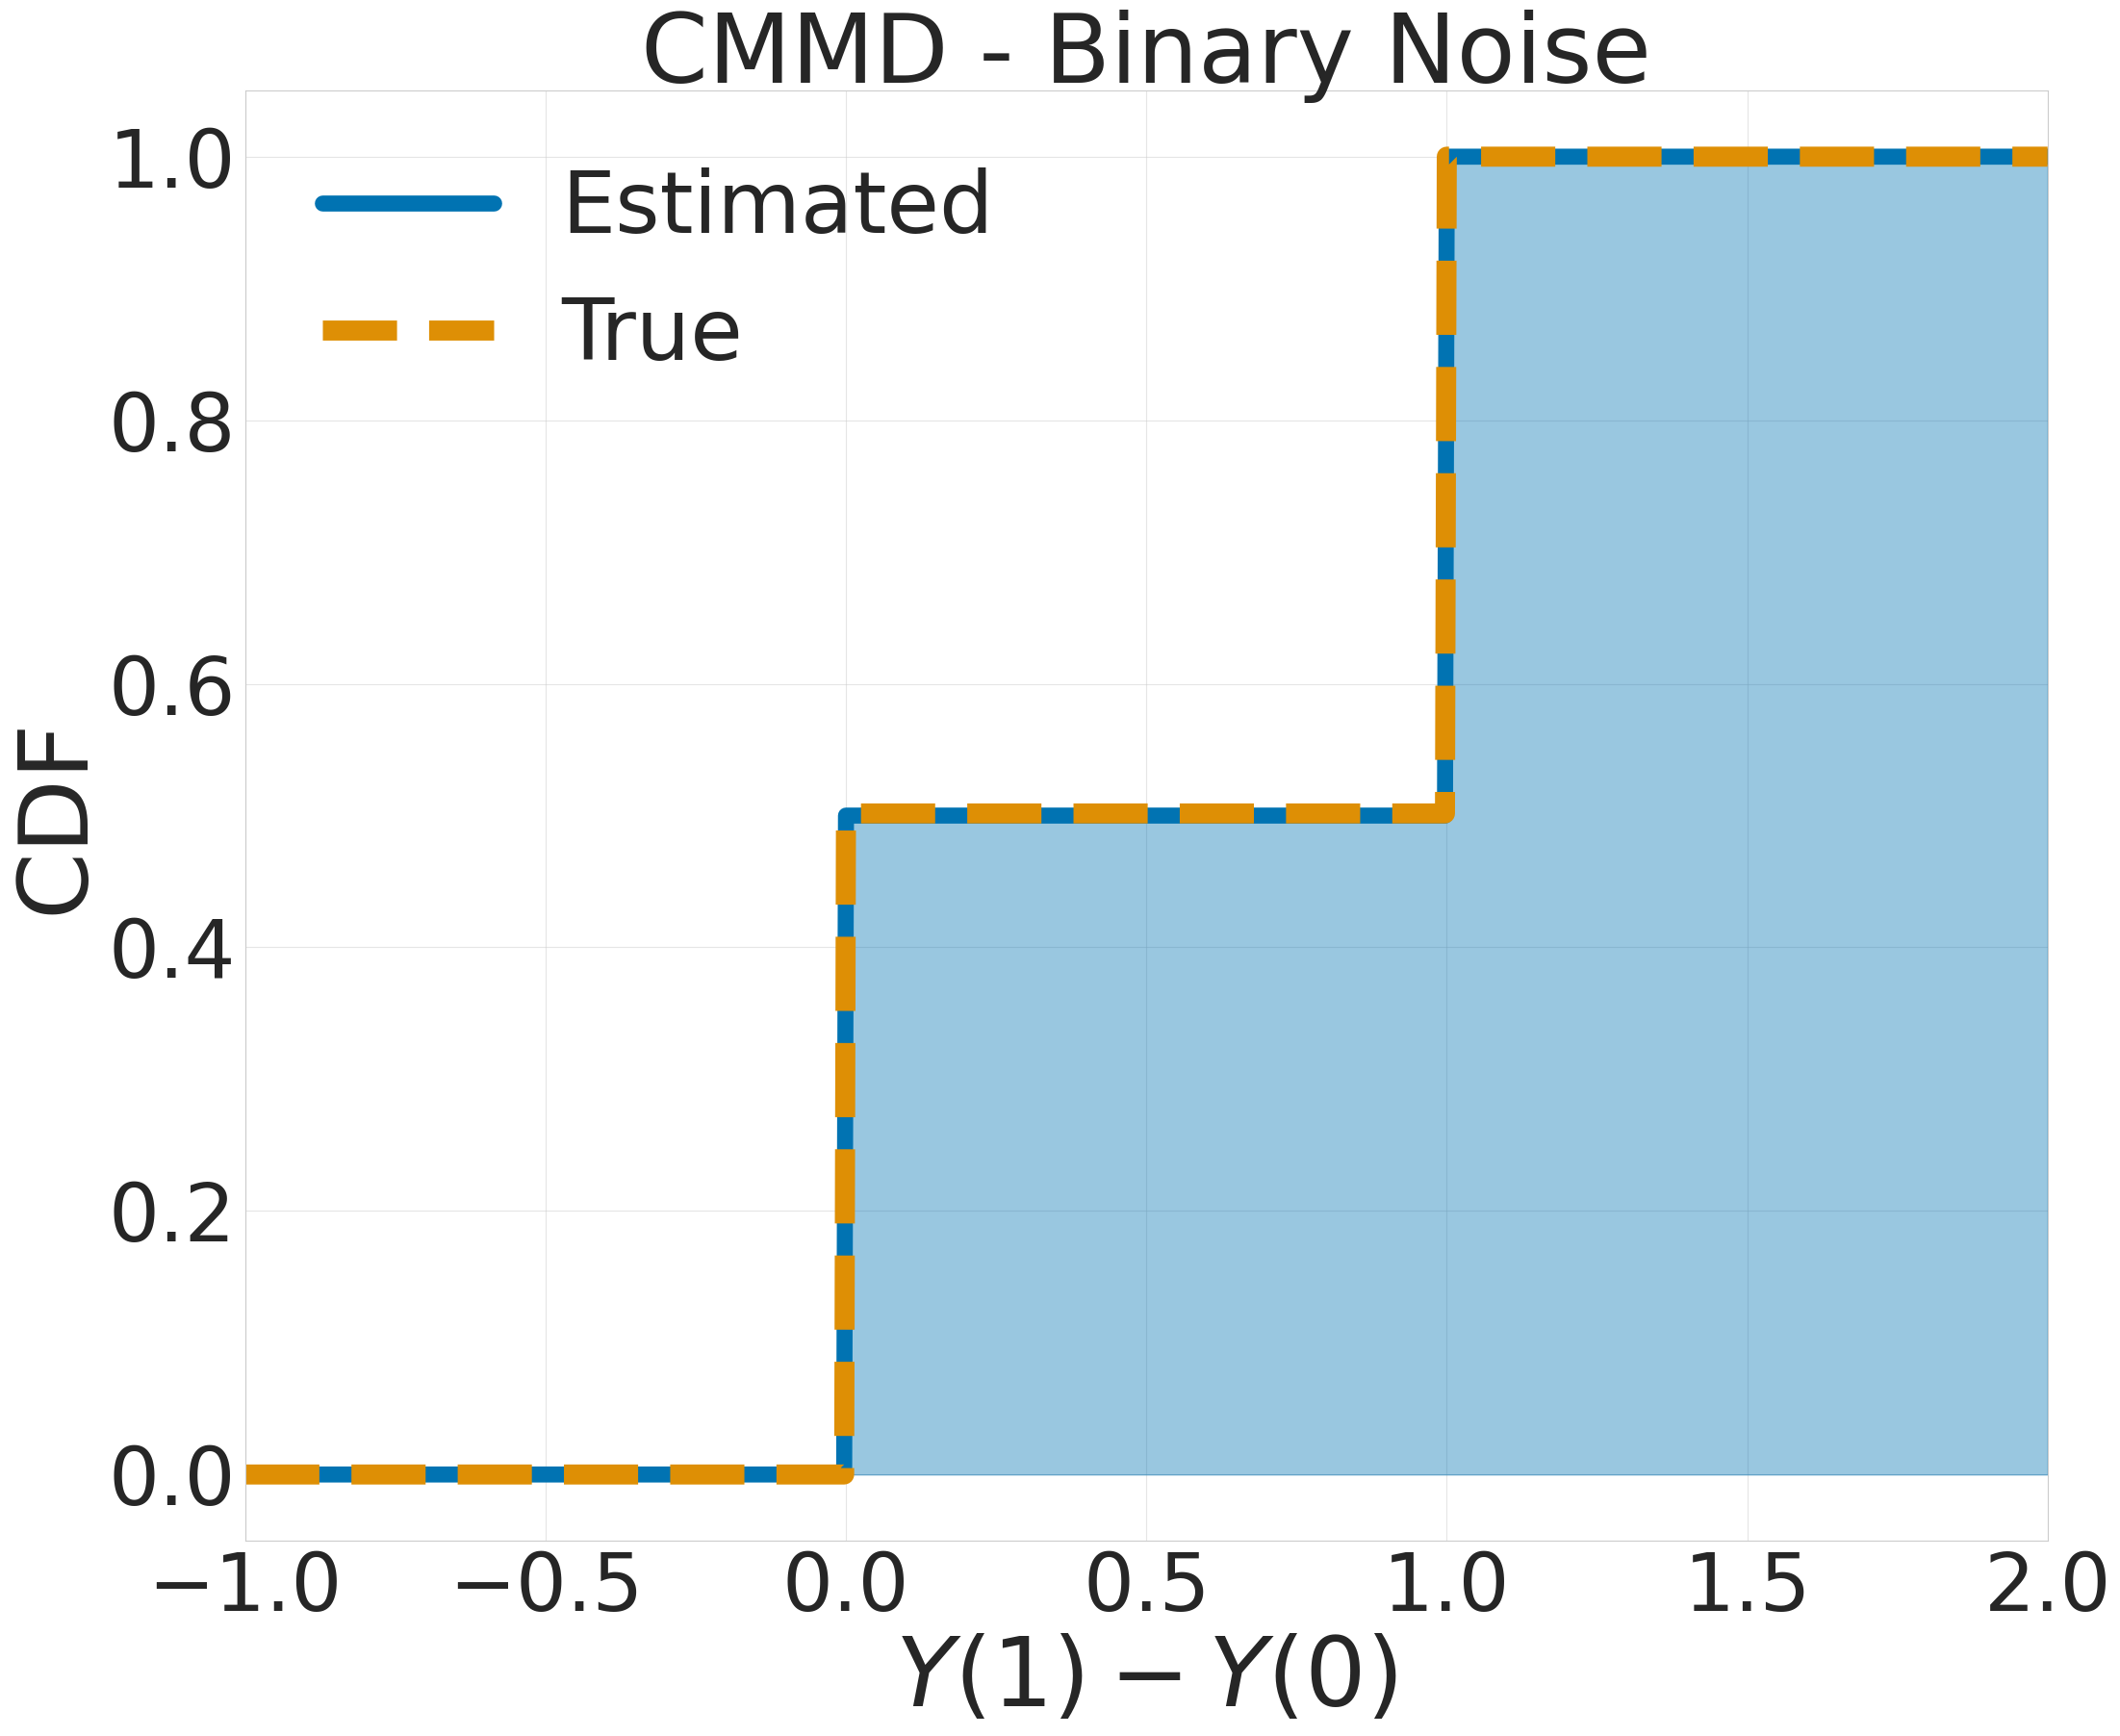

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

plt.rcParams.update({
    'font.size': 72,
    'axes.titlesize': 72,
    'axes.labelsize': 72,
    'xtick.labelsize': 48,
    'ytick.labelsize': 48
})
sns.set_style("whitegrid")

# Define fixed x-grid
x_grid = np.linspace(-1, 2, 1000)

# Sort inputs
delta_sorted = np.sort(delta)
true_delta_sorted = np.sort(true_delta)

# Compute empirical CDFs on fixed grid
cdf_delta = np.searchsorted(delta_sorted, x_grid, side="right") / len(delta_sorted)
cdf_true = np.searchsorted(true_delta_sorted, x_grid, side="right") / len(true_delta_sorted)

# Colors
col_data, col_true = sns.color_palette("colorblind", 2)

# Plot
fig, ax = plt.subplots(figsize=(24, 20))  # ⬅️ Doubled size

ax.plot(x_grid, cdf_delta, color=col_data, lw=12, label="Estimated")
ax.fill_between(x_grid, 0, cdf_delta, color=col_data, alpha=0.4)
ax.plot(x_grid, cdf_true, color=col_true, lw=15, ls="--", label="True")

# Labels with doubled fontsize
ax.set_xlabel(r"$Y(1) - Y(0)$", fontsize=72)
ax.set_ylabel("CDF", fontsize=72)
ax.set_title(r"CMMD - Binary Noise", fontsize=72)

# Tick label size adjustment
ax.tick_params(axis='x', labelsize=60)  # ⬅️ Much larger x-tick labels
ax.tick_params(axis='y', labelsize=60)

# Formatting
ax.set_xlim([-1, 2])
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.legend(frameon=False, fontsize=64)
ax.grid(alpha=0.5)
fig.tight_layout()
fig.savefig("cocycles_misspec_discrete_large.png", bbox_inches="tight")
plt.show()
